# Inventory Forecast Optimization Project


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# TensorFlow imports (to be run in local/Colab)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## Load and Preview Data

In [4]:
# Load inventory and demand datasets
inventory_df = pd.read_csv("C:/Users/aksab/Downloads/inventory_data.csv")
demand_df = pd.read_csv("C:/Users/aksab/Downloads/demand_signals.csv")

# Preview datasets
display(inventory_df.head())
display(demand_df.head())


,product_id,fab_location,lead_time_days,safety_stock,current_inventory,reorder_point
0,A1,Malaysia,16,121,174,103
1,A2,Austin,13,110,187,82
2,A3,Germany,22,70,216,101
3,B1,Malaysia,24,132,199,132
4,B2,Taiwan,20,136,203,81


,week,product_id,demand_forecast
0,2023-01-01,A1,167
1,2023-01-01,A2,187
2,2023-01-01,A3,109
3,2023-01-01,B1,117
4,2023-01-01,B2,81


## Merge Inventory and Demand Data for Analysis

In [5]:
# Focus on one product for demonstration
product_focus = 'A1'
merged_df = pd.merge(demand_df, inventory_df, on='product_id')
product_df = merged_df[merged_df['product_id'] == product_focus].copy()
product_df['week'] = pd.to_datetime(product_df['week'])
product_df.sort_values('week', inplace=True)


## Simulate Inventory Movement and Stockouts

In [6]:
product_df['inventory_level'] = product_df['current_inventory'].iloc[0]
product_df['order_placed'] = False
product_df['stockout'] = False

for i in range(1, len(product_df)):
    demand = product_df.iloc[i]['demand_forecast']
    prev_inventory = product_df.iloc[i-1]['inventory_level']
    reorder_point = product_df.iloc[i]['reorder_point']
    lead_time = product_df.iloc[i]['lead_time_days']
    
    inventory_level = prev_inventory - demand
    if inventory_level < 0:
        inventory_level = 0
        product_df.loc[product_df.index[i], 'stockout'] = True

    if inventory_level <= reorder_point and not product_df.iloc[i]['order_placed']:
        arrival_index = i + lead_time if i + lead_time < len(product_df) else -1
        product_df.loc[product_df.index[arrival_index], 'inventory_level'] += product_df.iloc[i]['safety_stock']
        product_df.loc[product_df.index[i], 'order_placed'] = True

    product_df.loc[product_df.index[i], 'inventory_level'] = inventory_level


## Calculate Key Performance Indicators (KPIs)

In [7]:
stockout_rate = product_df['stockout'].mean()
average_inventory = product_df['inventory_level'].mean()
reorder_frequency = product_df['order_placed'].sum()
service_level = 1 - stockout_rate

kpi_summary = pd.DataFrame({
    'KPI': ['Stockout Rate', 'Average Inventory Level', 'Reorder Frequency', 'Service Level'],
    'Value': [f"{stockout_rate:.2%}", f"{average_inventory:.2f} units", reorder_frequency, f"{service_level:.2%}"],
    'Definition': [
        "Percentage of weeks when demand could not be fully met due to insufficient inventory.",
        "Average inventory units available across all weeks.",
        "Total number of times a reorder was triggered due to inventory falling below reorder point.",
        "Percentage of weeks with no stockouts—indicates how well demand was served."
    ]
})
display(kpi_summary)


,KPI,Value,Definition
0,Stockout Rate,96.15%,Percentage of weeks when demand could not be f...
1,Average Inventory Level,3.94 units,Average inventory units available across all w...
2,Reorder Frequency,51,Total number of times a reorder was triggered ...
3,Service Level,3.85%,Percentage of weeks with no stockouts—indicate...


## Visualize KPIs

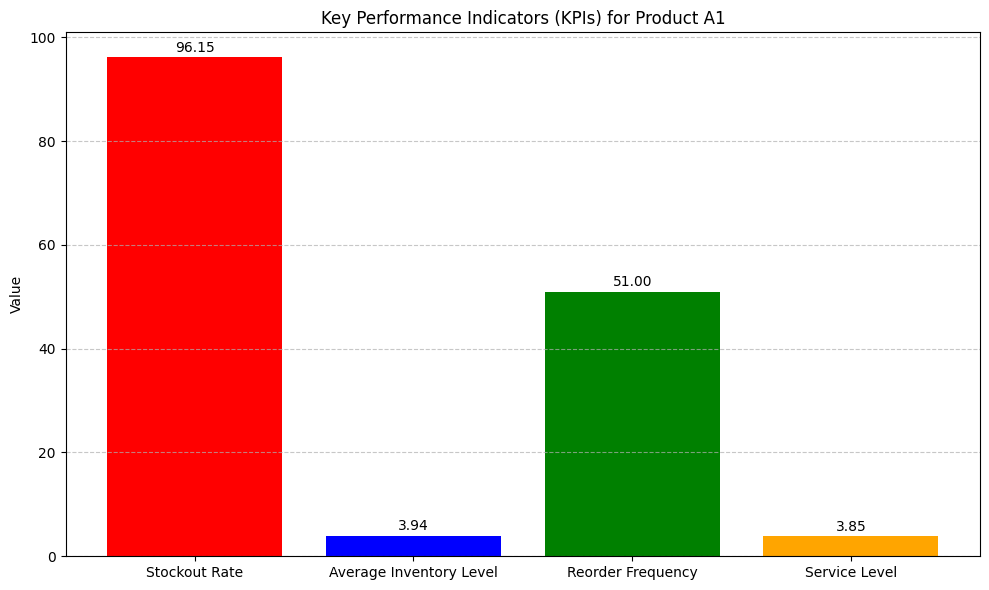

In [8]:
plt.figure(figsize=(10, 6))
kpi_values_fixed = [float(v.strip('%').replace(' units', '')) if isinstance(v, str) else float(v) for v in kpi_summary['Value']]
bars = plt.bar(kpi_summary['KPI'], kpi_values_fixed, color=['red', 'blue', 'green', 'orange'])
plt.title('Key Performance Indicators (KPIs) for Product A1')
plt.ylabel('Value')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Forecast Demand using ARIMA

C:\Users\aksab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\aksab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\aksab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


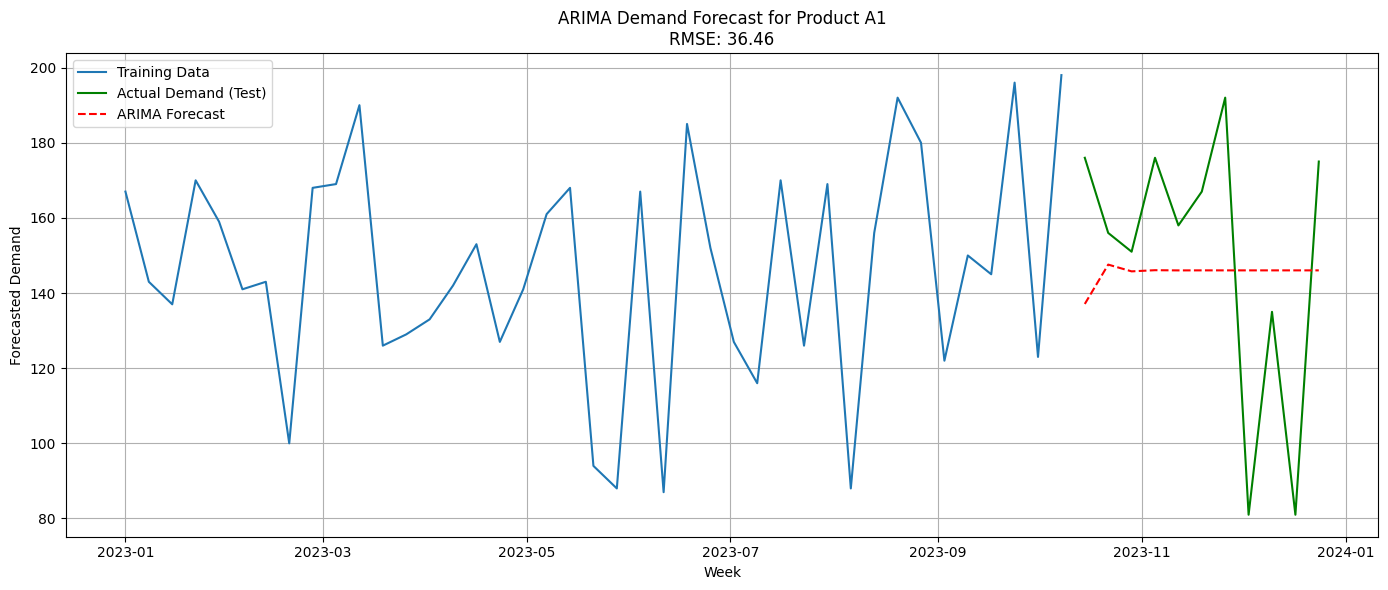

In [12]:
demand_series = product_df.set_index('week')['demand_forecast']
train_size = int(len(demand_series) * 0.8)
train, test = demand_series[:train_size], demand_series[train_size:]

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
rmse = np.sqrt(mean_squared_error(test, forecast))

plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Demand (Test)', color='green')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f'ARIMA Demand Forecast for Product A1\nRMSE: {rmse:.2f}')
plt.xlabel('Week')
plt.ylabel('Forecasted Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Forecast Demand using LSTM


C:\Users\aksab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


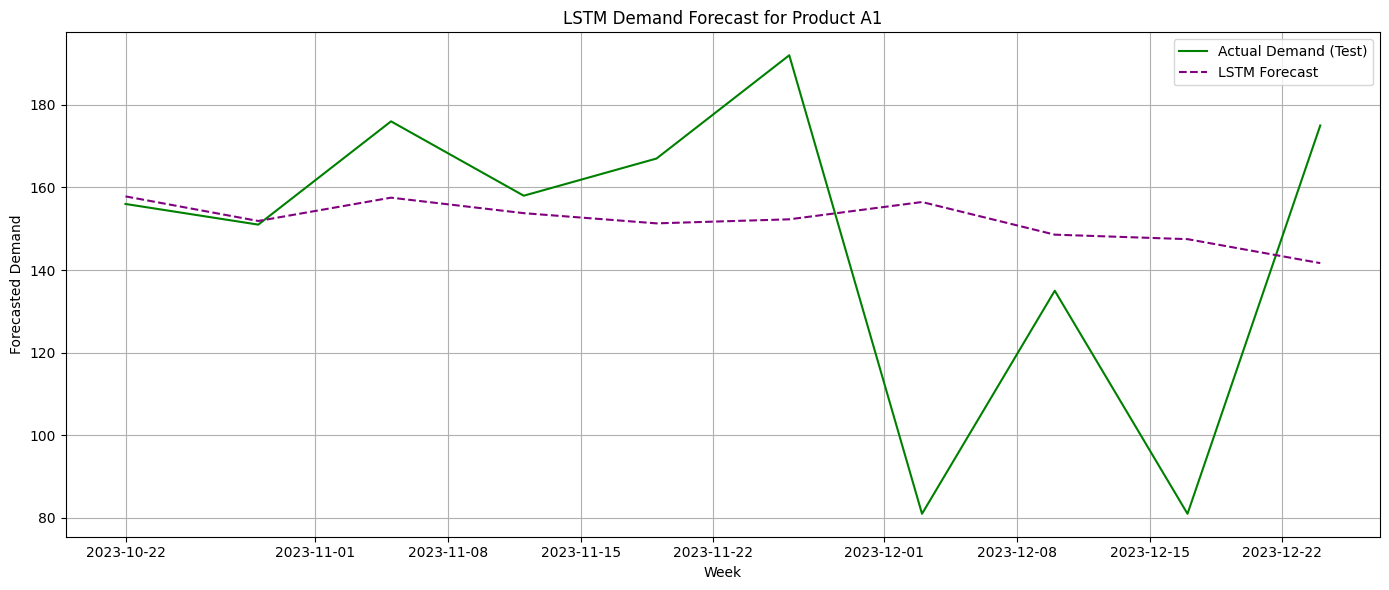

In [14]:
lstm_data = demand_series.values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_data)

def create_sequences(data, lookback=4):
     X, y = [], []
     for i in range(len(data) - lookback):
         X.append(data[i:i + lookback])
         y.append(data[i + lookback])
     return np.array(X), np.array(y)

lookback = 4
X, y = create_sequences(scaled_data, lookback)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(lookback, 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(X_train, y_train, epochs=50, batch_size=4, verbose=0)

y_pred = model1.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

test_weeks = product_df['week'].iloc[lookback + split_index:lookback + split_index + len(y_pred)]
plt.figure(figsize=(14, 6))
plt.plot(test_weeks, y_test_inverse, label='Actual Demand (Test)', color='green')
plt.plot(test_weeks, y_pred_inverse, label='LSTM Forecast', color='purple', linestyle='--')
plt.title('LSTM Demand Forecast for Product A1')
plt.xlabel('Week')
plt.ylabel('Forecasted Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Safety Stock vs Demand Variability**

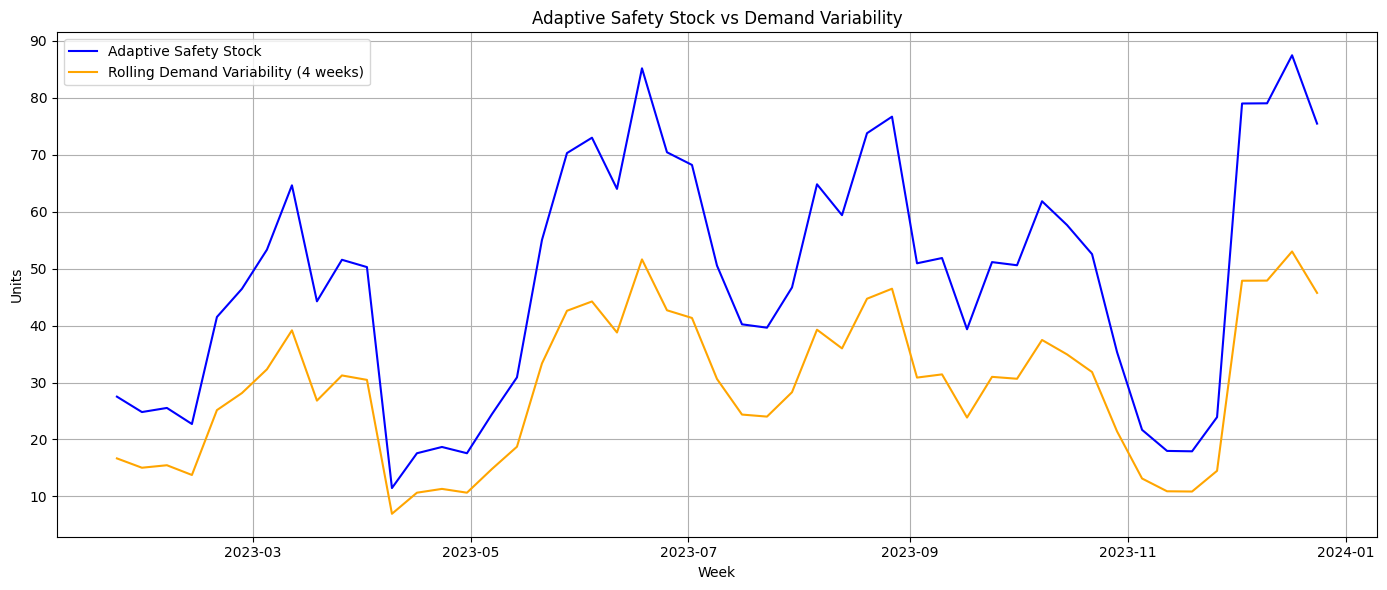

In [17]:
# Make safety stock proportional to recent demand variability
product_df['adaptive_safety_stock'] = product_df['demand_forecast'].rolling(window=4).std() * 1.65  # 95% CI assumption

# Plot adaptive safety stock vs demand variability
plt.figure(figsize=(14, 6))
plt.plot(product_df['week'], product_df['adaptive_safety_stock'], label='Adaptive Safety Stock', color='blue')
plt.plot(product_df['week'], product_df['demand_variability'], label='Rolling Demand Variability (4 weeks)', color='orange')
plt.title('Adaptive Safety Stock vs Demand Variability')
plt.xlabel('Week')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Lead Time Impact Analysis**

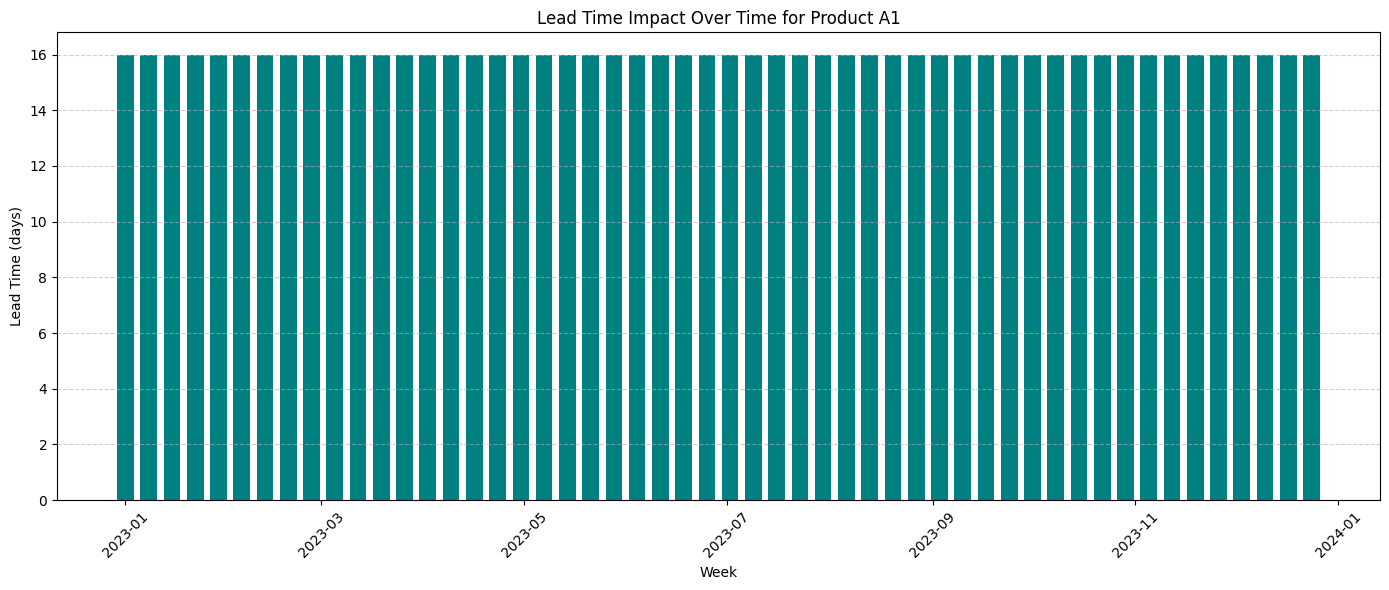

In [16]:
# Create a lead time impact bar plot
plt.figure(figsize=(14, 6))
plt.bar(product_df['week'], product_df['lead_time_days'], color='teal', width=5)
plt.title('Lead Time Impact Over Time for Product A1')
plt.xlabel('Week')
plt.ylabel('Lead Time (days)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


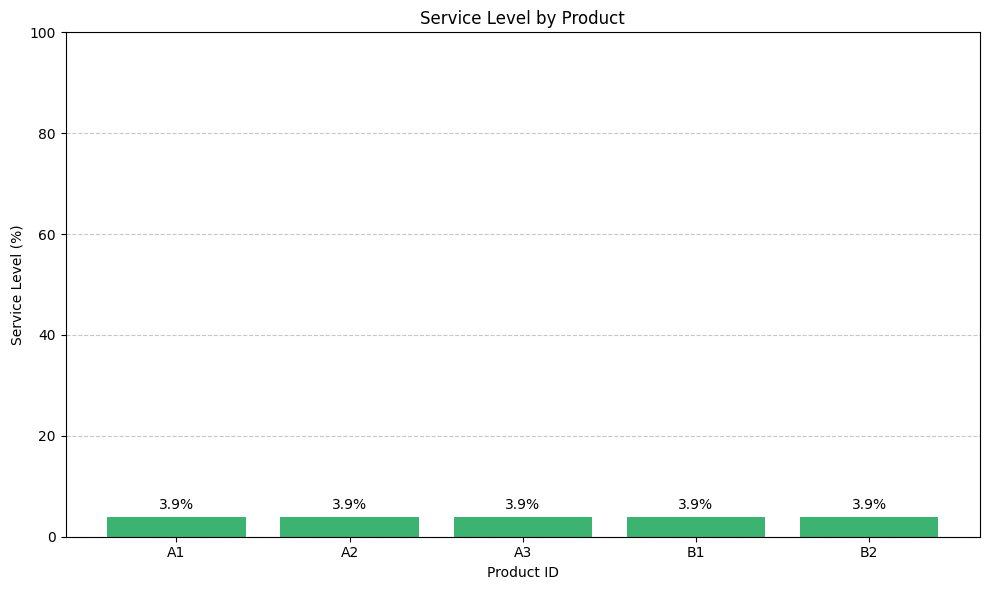

In [19]:
# Convert week column to datetime
demand_df['week'] = pd.to_datetime(demand_df['week'])

# Merge inventory and demand data
merged_df = pd.merge(demand_df, inventory_df, on='product_id')
merged_df.sort_values(['product_id', 'week'], inplace=True)

# Initialize a dictionary to store service levels
service_levels = {}

# Calculate service level for each product
for product in merged_df['product_id'].unique():
    df = merged_df[merged_df['product_id'] == product].copy()
    df = df.reset_index(drop=True)
    df['inventory_level'] = df['current_inventory'].iloc[0]
    df['stockout'] = False

    for i in range(1, len(df)):
        demand = df.loc[i, 'demand_forecast']
        inventory = df.loc[i-1, 'inventory_level'] - demand
        inventory = max(inventory, 0)
        df.loc[i, 'stockout'] = inventory == 0
        df.loc[i, 'inventory_level'] = inventory
        # Insert this inside the for-loop where inventory is being updated
        if inventory <= df.loc[i, 'reorder_point']:
            inventory += df.loc[i, 'safety_stock']  # simulate replenishment


    service_level = 1 - df['stockout'].mean()
    service_levels[product] = round(service_level * 100, 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(service_levels.keys(), service_levels.values(), color='mediumseagreen')
plt.title('Service Level by Product')
plt.xlabel('Product ID')
plt.ylabel('Service Level (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, (k, v) in enumerate(service_levels.items()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()
